In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

Step 0: load our data

In [3]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/metadata/fully_concatenated_data.csv", lineterminator='\n')

In [4]:
data.iloc[:, 10:35]

,caption,is_ad,Post ID,Sponsorship label,JSON file,Image files,Name,Followers,Followees,Posts,...,Year,Month,Day,Hour,Day of Week (Number),Day of Week (String),Is_English,Detected_Language,Image_Count,image_0
0,Preseason game 2 outfit.Vintage hat (which I t...,NaN,184752,0,1354915397698488656.json,1354915397698488656.jpg,Rocketgirl,6453,710,1059,...,2016,10,6,7,3,Thursday,True,en,1,0.483804
1,Took Heidi to meet Santa today at @petsmart. S...,NaN,184764,0,1666974101448132749.json,1666974101448132749.jpg,Rocketgirl,6453,710,1059,...,2017,12,10,20,6,Sunday,True,en,1,1.257535
2,4/18/18- Game 2 Rockets vs Wolves. Light up ha...,NaN,184776,0,1768273356099895999.json,1768273356099895999.jpg,Rocketgirl,6453,710,1059,...,2018,4,29,15,6,Sunday,True,en,1,1.015909
3,4/18/18- Game 2 vs T-Wolves pics. Section 107 ...,False,184777,0,1770557472379860655.json,1770557376598782147.jpg,Rocketgirl,6453,710,1059,...,2018,5,2,18,2,Wednesday,True,en,7,0.612580
4,Season opener outfit. The left is kind of what...,NaN,184780,0,1899586748141399903.json,1899586748141399903.jpg,Rocketgirl,6453,710,1059,...,2018,10,27,19,5,Saturday,True,en,1,0.961807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196174,Making 2018 my epic skin year. I’ve locked dow...,False,1519643,0,1689162745453535364.json,1689162599693269884.jpg,Z o e,4487,858,713,...,2018,1,10,11,2,Wednesday,True,en,2,0.160993
196175,The perfect storm ☁️ wearing @boohoo rib knit ...,NaN,1519644,0,1695128267039160652.json,1695128267039160652.jpg,Z o e,4487,858,713,...,2018,1,18,17,3,Thursday,True,en,1,0.337574
196176,"Of all the Christmas movies, I relate to the G...",NaN,1519650,0,1926097425697935397.json,1926097425697935397.jpg,Z o e,4487,858,713,...,2018,12,3,9,0,Monday,True,en,1,0.860733
196177,Werbung\nGuten Morgen ihr Lieben. Ich gehe mal...,NaN,1403159,0,1717335338709878476.json,1717335338709878476.jpg,Zeynep,19215,401,149,...,2018,2,18,8,6,Sunday,False,de,1,0.039804


In [5]:
# List of image and text feature columns to keep
image_columns = [f'image_{i}' for i in range(0, 2049)]
text_columns = [f'text_{i}' for i in range(0, 768)]

# Additional columns you want to keep
additional_columns_to_keep = ['like_count', 'comment_count', 'post_id', 'Followers', 'Username', 'Followees', 'Posts',
                              'Year', 'Month', 'Day of Week (String)', 'Hour', 'Language', 'Is_English', 'Image_Count', 'Sponsorship label', 'is_video', 'Image_Count', 'Detected_Language']

# Combine both lists of columns to keep
columns_to_keep = additional_columns_to_keep #+ text_columns + image_columns

# Drop all columns except those specified in columns_to_keep
columns_to_drop = [col for col in data.columns if col not in columns_to_keep]

# Drop the unwanted columns from the dataframe
data_2 = data.drop(columns=columns_to_drop)


# Maybe don't delete category and detected languages
# Same with comments disabled and video
# potential columns to add or not:
#'comments_disabled',
#'is_video'
# Category
data_2.head(10)

# Filter image count to 10 or less, which is what is realistic in the industry
data_2 = data_2[data_2['Image_Count'] <= 1]

In [ ]:
data_2.head()

,Username,post_id,like_count,comment_count,is_video,Sponsorship label,Followers,Followees,Posts,Year,Month,Hour,Day of Week (String),Is_English,Image_Count
0,00_rocketgirl,1354915397698488656,293,6,False,0,6453,710,1059,2016,10,7,Thursday,True,1
1,00_rocketgirl,1666974101448132749,73,2,False,0,6453,710,1059,2017,12,20,Sunday,True,1
2,00_rocketgirl,1768273356099895999,164,4,False,0,6453,710,1059,2018,4,15,Sunday,True,1
4,00_rocketgirl,1899586748141399903,116,2,False,0,6453,710,1059,2018,10,19,Saturday,True,1
9,0hkris,1514786978688118458,269,0,False,0,12630,7069,261,2017,5,21,Sunday,True,1


In [6]:
# Count observations per month
Username = data_2['Username'].value_counts()

In [7]:
Username

Username
laurenashleypatao    45
kylieek_jenner       44
thebeautyelite       40
whatwhitwore         39
alexingamua          38
                     ..
skylersimpsonn        1
skykinz               1
jennyrichfit          1
jenremauro            1
littlepaperswan       1
Name: count, Length: 27893, dtype: int64

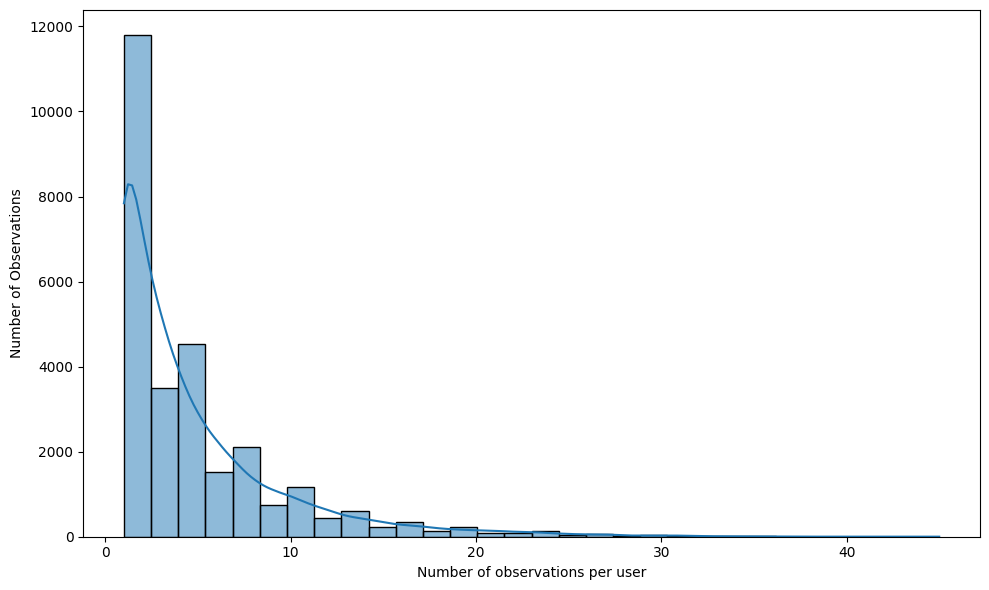

In [11]:
# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(Username, bins=30, kde=True)
plt.title('')
plt.xlabel('Number of observations per user')
plt.ylabel('Number of Observations')
plt.tight_layout()

# Save the plot as a JPEG file if needed
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/EDA/out/observations_per_user.jpg', format='jpg', dpi=300)

# Show the plot
plt.show()

Let's match the asthetics of my graphs with my thesis

In [ ]:
# Set the font to a serif font that closely matches Palatino used in ClassicThesis
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Palatino Linotype' if 'Palatino Linotype' in matplotlib.font_manager.findSystemFonts() else 'Palatino'
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['legend.fontsize'] = 11
matplotlib.rcParams['axes.titlesize'] = 12

Time visualizations

In [ ]:
  # Count observations per month
  month_counts = data_2['Month'].value_counts().sort_index()

In [ ]:
month_counts

Month
1     10735
2     11546
3     13564
4     11827
5     11398
6     12174
7     12246
8      8725
9      9577
10    10454
11    10753
12    10643
Name: count, dtype: int64

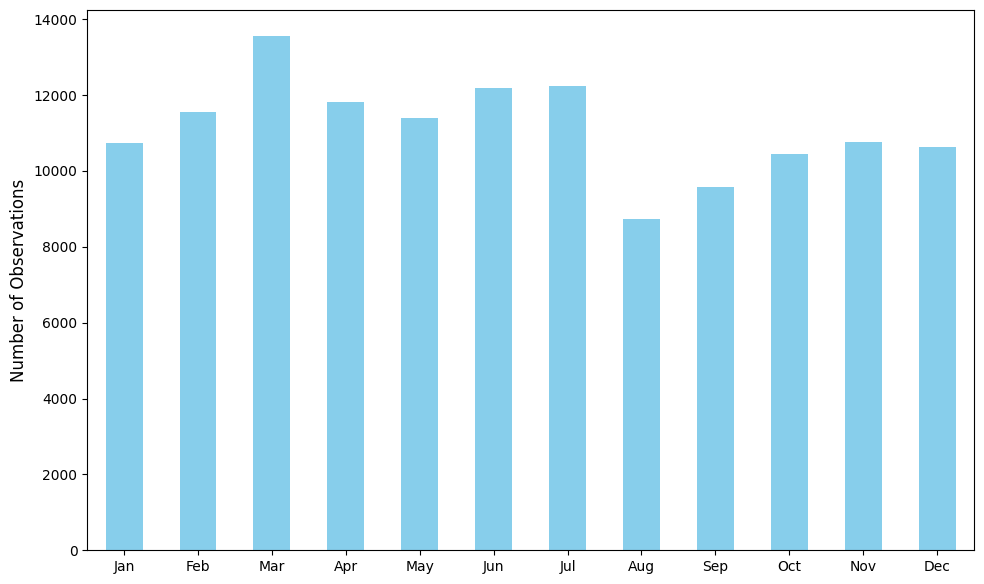

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
month_counts.plot(kind='bar', color='skyblue')
plt.title('')
plt.xlabel('')
plt.ylabel('Number of Observations')
plt.xticks(ticks=range(len(month_counts)), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.tight_layout()

# Save the plot as a JPEG file if needed
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/EDA/out/observations_per_month.jpg', format='jpg', dpi=300)

# Show the plot
plt.show()

Now let's visualize days

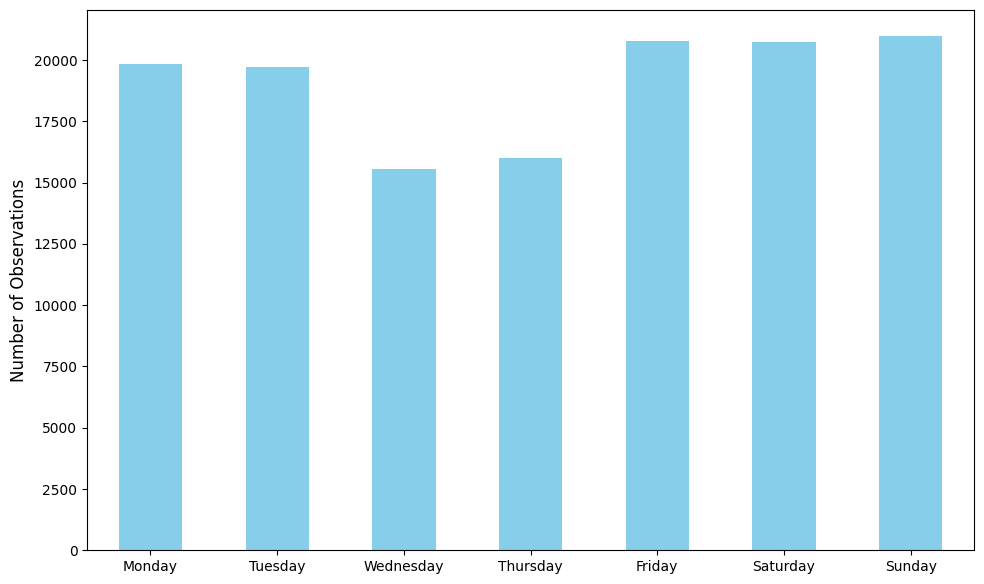

In [ ]:
# Count observations per month
day_counts = data_2['Day of Week (String)'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
day_counts.plot(kind='bar', color='skyblue')
plt.title('')
plt.ylabel('Number of Observations')
plt.xlabel('')
plt.xticks(ticks=range(len(day_counts)), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.tight_layout()

# Save the plot as a JPEG file if needed
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/EDA/out/observations_per_day.jpg', format='jpg', dpi=300)

# Show the plot
plt.show()

In [ ]:
# Count observations per month
english = data_2['Is_English'].value_counts().sort_index()

english

Is_English
False     20432
True     113210
Name: count, dtype: int64

In [ ]:
# Count observations per month
language = data_2['Detected_Language'].value_counts()

language

Detected_Language
en    113210
it      4730
fr      3379
de      3074
es      2754
       ...  
ee         1
yo         1
ny         1
xh         1
sm         1
Name: count, Length: 92, dtype: int64

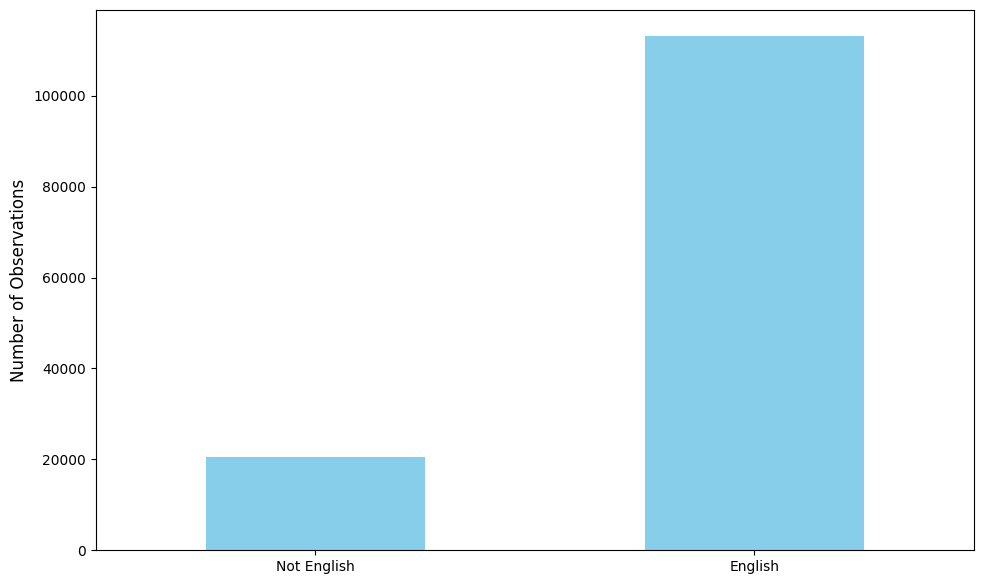

In [ ]:


# Plotting
plt.figure(figsize=(10, 6))
english.plot(kind='bar', color='skyblue')
plt.title('')
plt.ylabel('Number of Observations')
plt.xlabel('')
plt.xticks(ticks=range(len(english)), labels=['Not English', 'English'], rotation=0)
plt.tight_layout()

# Save the plot as a JPEG file if needed
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/EDA/out/observations_English.jpg', format='jpg', dpi=300)

# Show the plot
plt.show()